In [30]:
#Seaborn for quick analysis, matplotlib for presentation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [31]:
#Load dataset into dataframe
csv_path = 'Amazon Sale Report.csv'
df = pd.read_csv(csv_path)
df

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,True,NaN,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,Blazzer,L,On the Way,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,False,Easy Ship,NaN,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Trousers,3XL,Shipped,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128971,128970,406-6001380-7673107,05-31-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,...,INR,517.00,HYDERABAD,TELANGANA,500013.0,IN,False,NaN,NaN,NaN
128972,128971,402-9551604-7544318,05-31-22,Shipped,Amazon,Amazon.in,Expedited,T-shirt,M,Shipped,...,INR,999.00,GURUGRAM,HARYANA,122004.0,IN,False,NaN,NaN,NaN
128973,128972,407-9547469-3152358,05-31-22,Shipped,Amazon,Amazon.in,Expedited,Blazzer,XXL,Shipped,...,INR,690.00,HYDERABAD,TELANGANA,500049.0,IN,False,NaN,NaN,NaN
128974,128973,402-6184140-0545956,05-31-22,Shipped,Amazon,Amazon.in,Expedited,T-shirt,XS,Shipped,...,INR,1199.00,Halol,Gujarat,389350.0,IN,False,NaN,NaN,NaN


# Data Cleansing

In [32]:
#Drop columns with count 0 and change data type of Date
df.drop(columns=['New', 'PendingS'], inplace=True)
df['Date'] = df['Date'].astype('datetime64[ns]')

In [33]:
#Remove duplicate entries based on 'Order ID'
df = df.drop_duplicates(subset='Order ID')

In [36]:
#Extract year, month, and day from 'Date' column
df.loc[:, 'Year'] = df['Date'].dt.year
df.loc[:, 'Month'] = df['Date'].dt.month
df.loc[:, 'Day'] = df['Date'].dt.day

In [37]:
#Define column groups for numerical, date, and categorical data
numbers = ['Amount', 'Qty']
dates = ['Date', 'Date_year', 'Date_month', 'Date_day']
cats = ['Sales Channel', 'Fulfilment', 'fulfilled-by', 'ship-service-level', 'Category',
        'Size', 'Courier Status', 'Status', 'ship-country', 'ship-state', 'ship-city']

# Preliminary Data Visualization

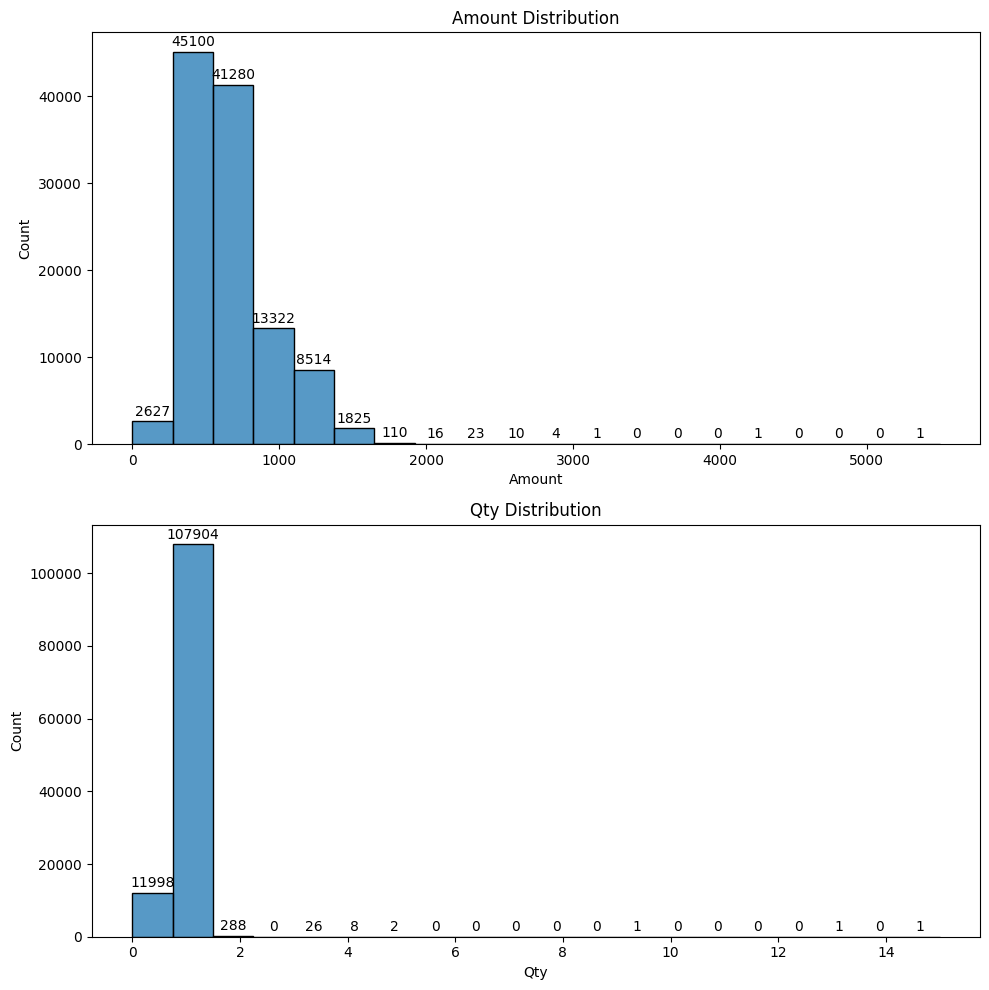

In [38]:
fig, axs = plt.subplots(len(numbers), figsize=(10, 10))

for idx, feature in enumerate(numbers):
    hist = sns.histplot(data=df, x=feature, bins=20, ax=axs[idx])
    axs[idx].set_title(f"{feature} Distribution")

    for patch in hist.patches:
        height = patch.get_height()
        hist.annotate(f'{height:.0f}', 
                      xy=(patch.get_x() + patch.get_width() / 2, height),
                      xytext=(0, 2), textcoords='offset points',
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [44]:
#Extract columns that represent parts of the date
time_cols = [col for col in df.columns if 'Year' in col or 'Month' in col or 'Day' in col]
time_cols

['Year', 'Month', 'Day']

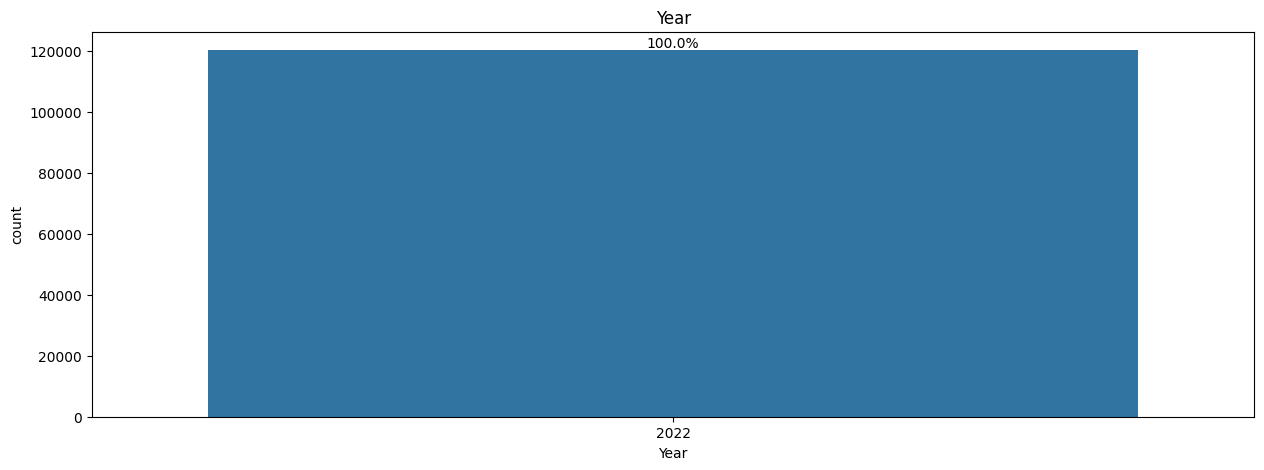

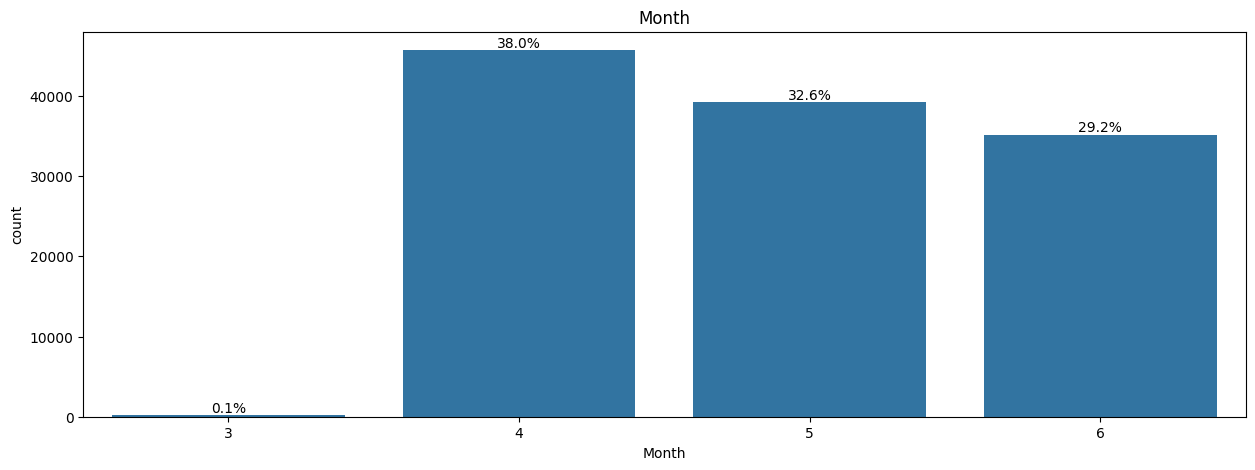

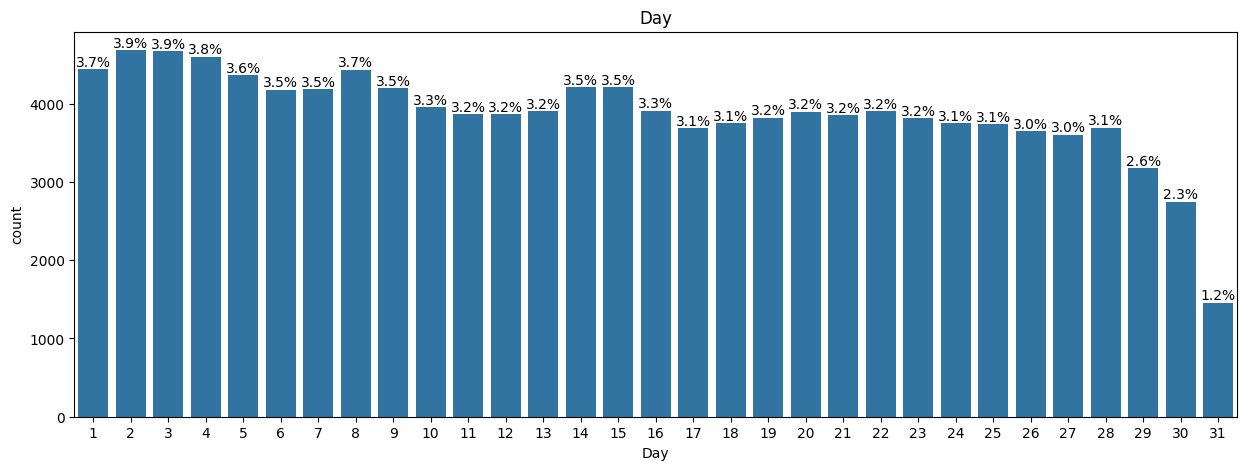

In [45]:
for time in time_cols:
    plt.figure(figsize=(15, 5)) 
    countplot = sns.countplot(data=df, x=time)
    plt.title(time)

    total = len(df[time])

    for p in countplot.patches:
        height = p.get_height()
        percentage = f'{(height / total) * 100:.1f}%'
        countplot.annotate(percentage, 
                           xy=(p.get_x() + p.get_width() / 2, height), 
                           xytext=(0, 0),
                           textcoords='offset points', 
                           ha='center', va='bottom')
    
    plt.show()

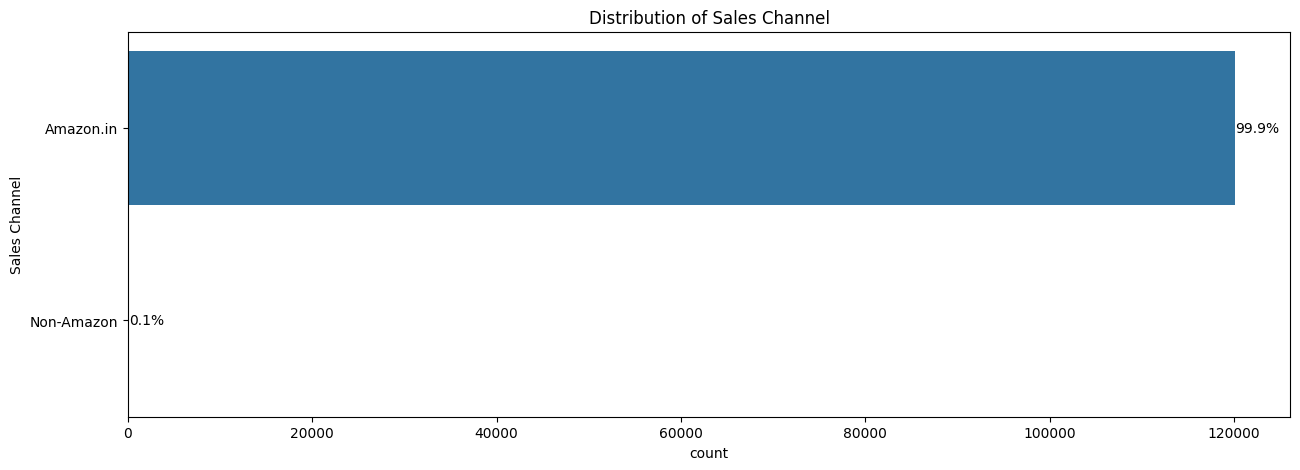

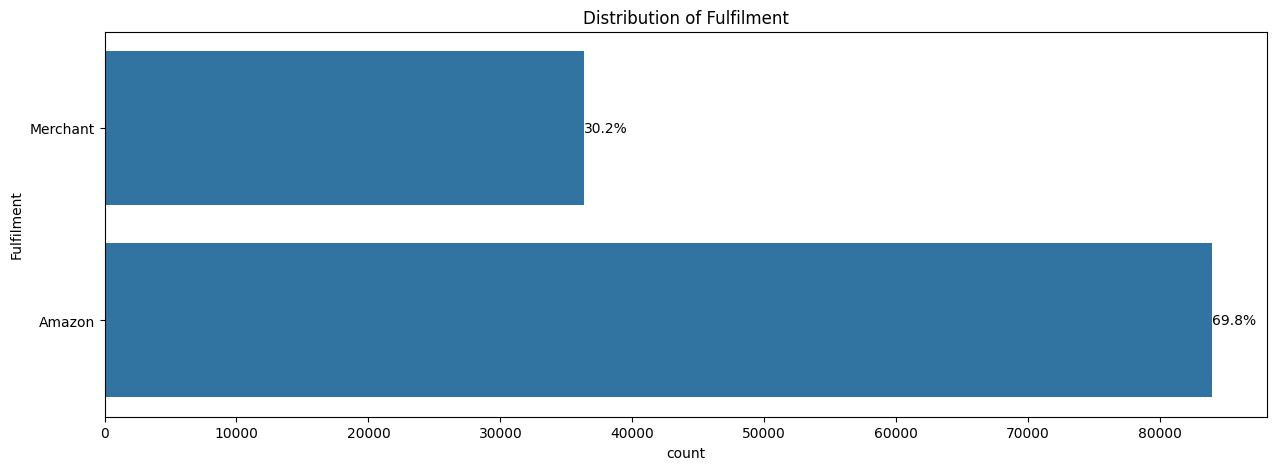

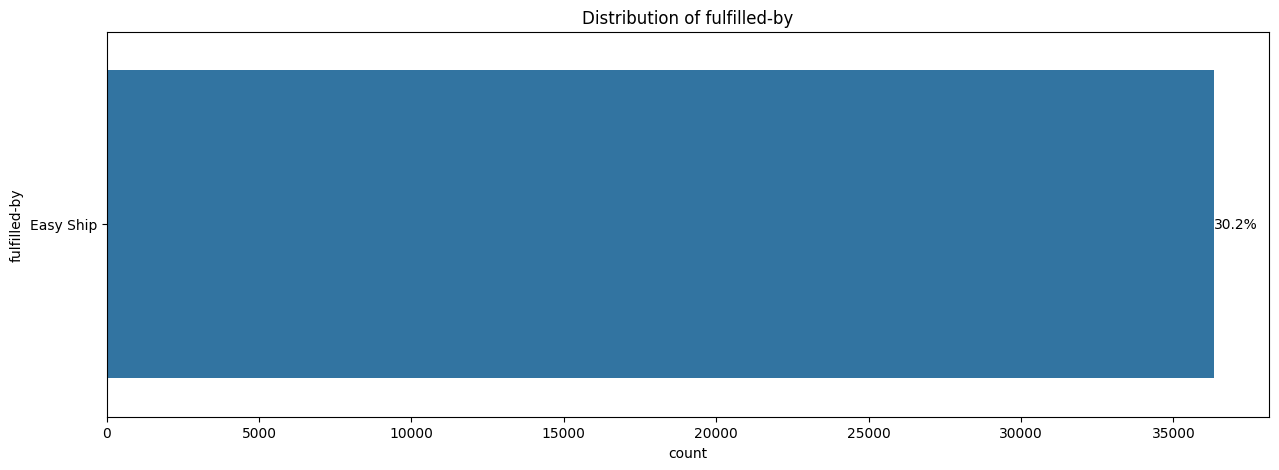

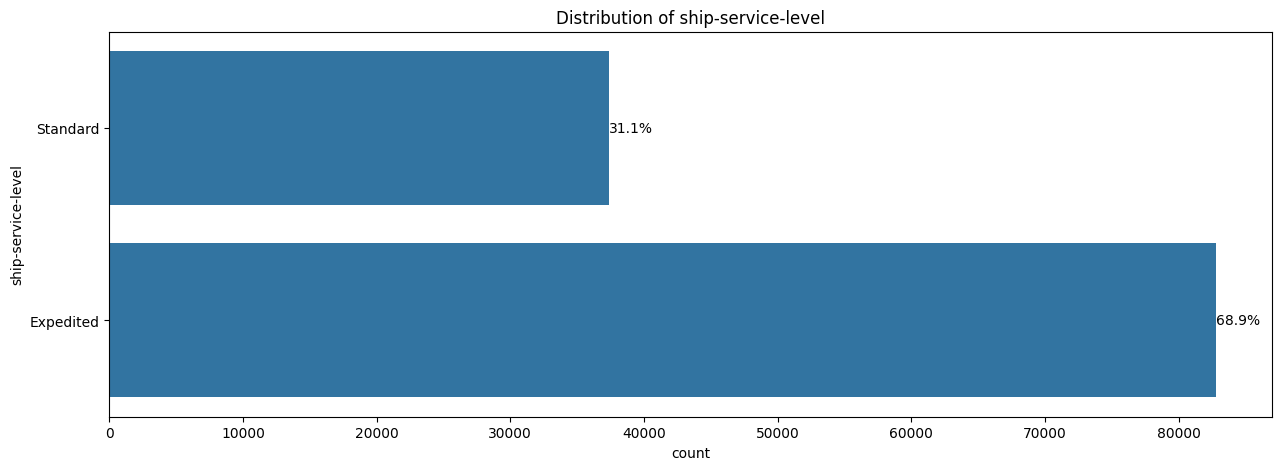

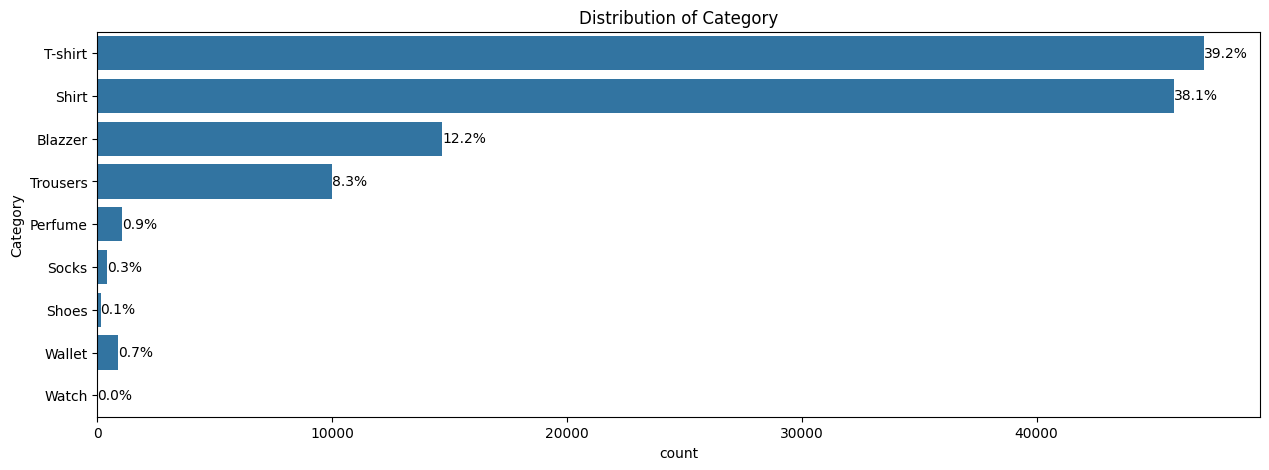

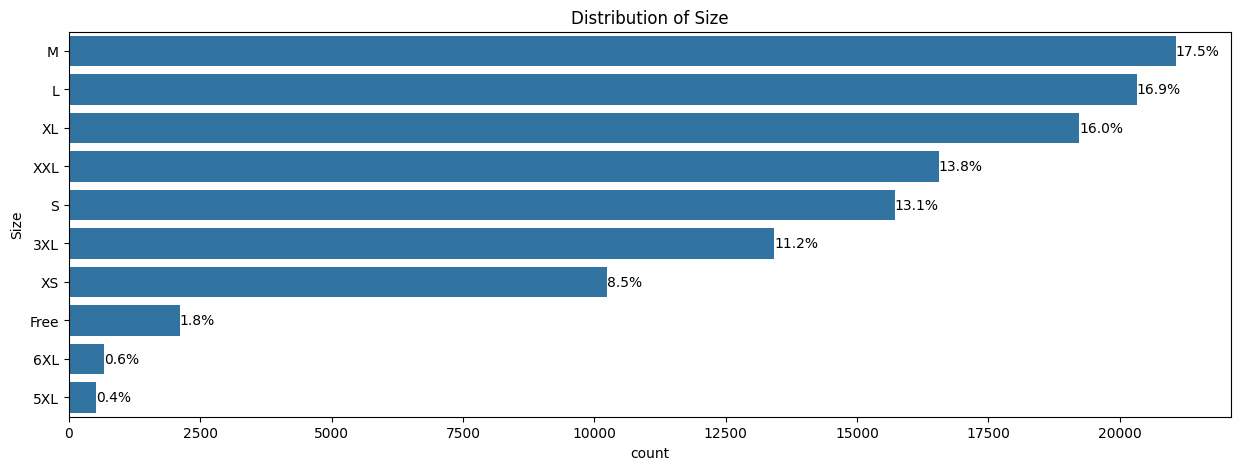

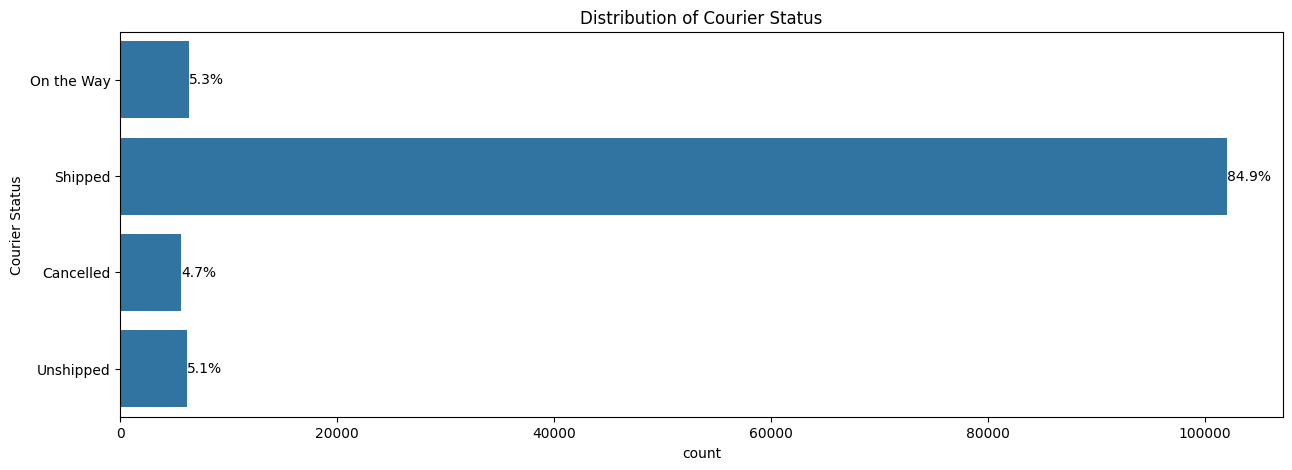

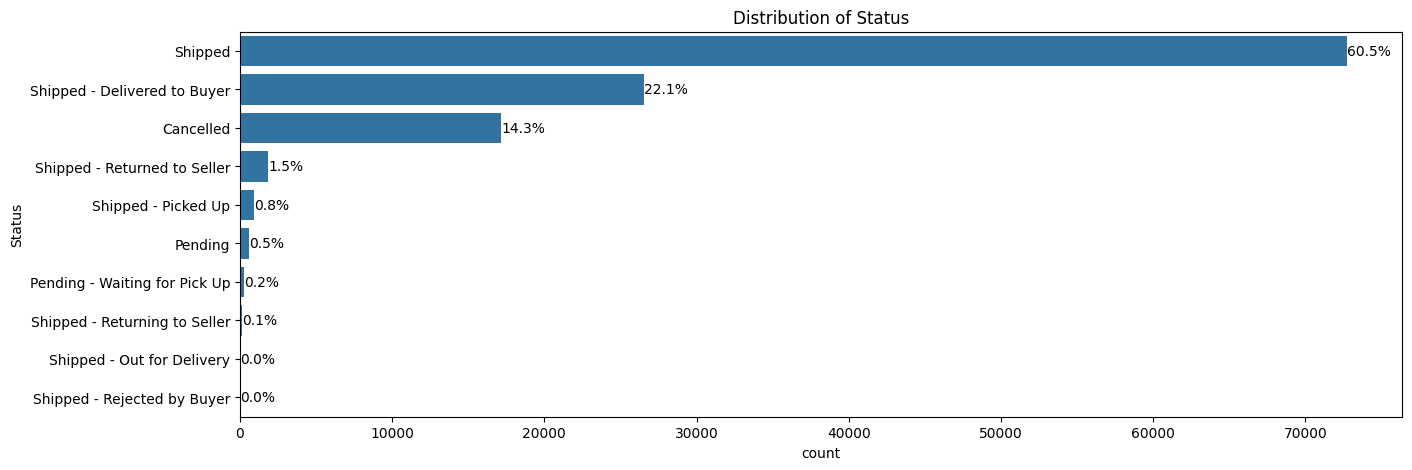

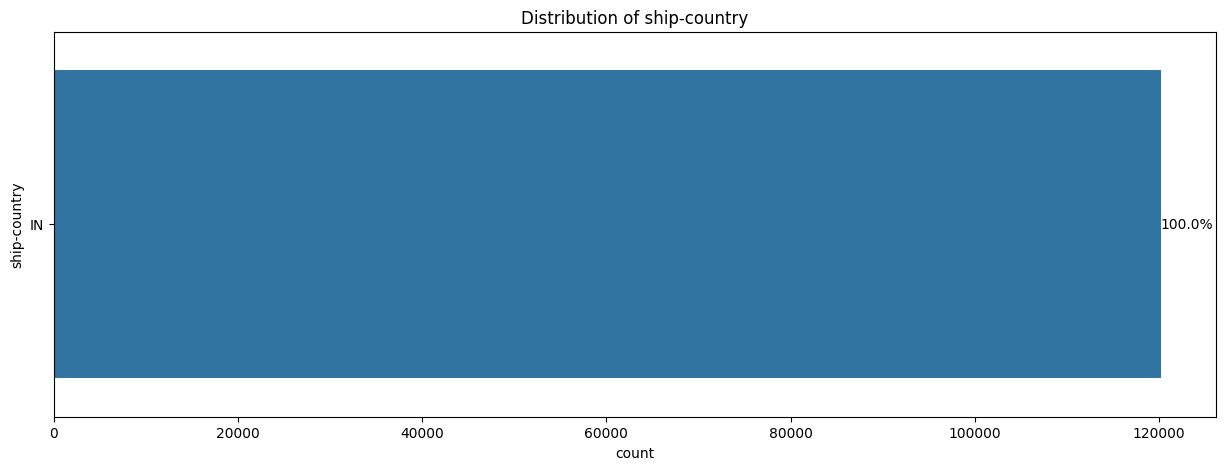

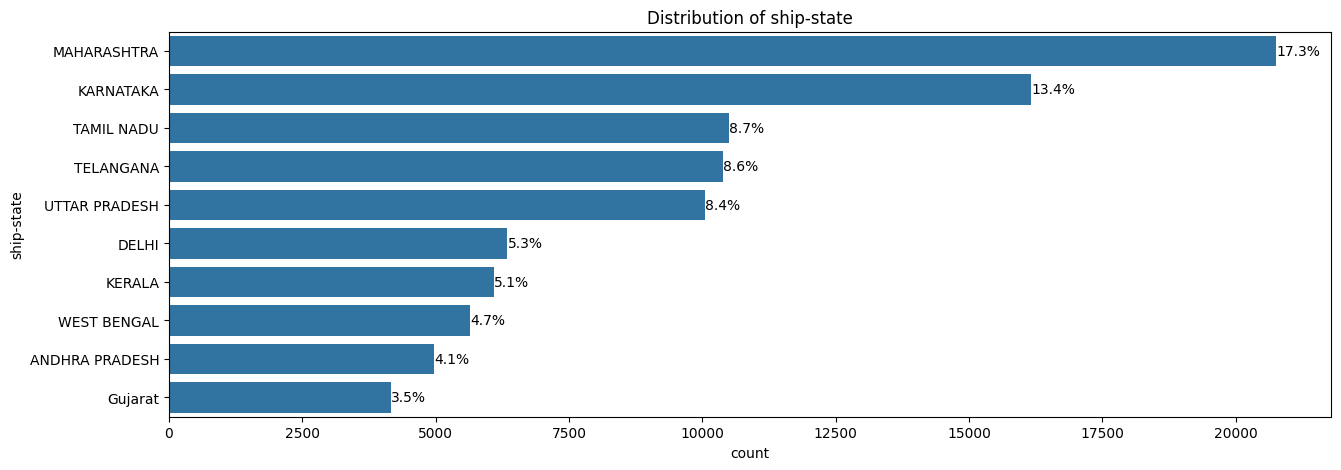

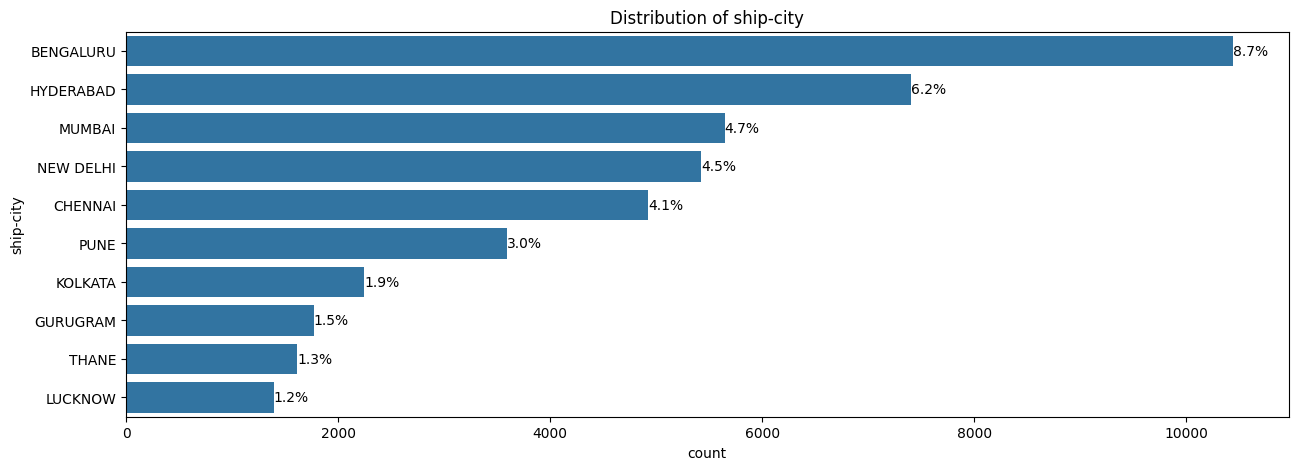

In [46]:
for cat in cats:
    plt.figure(figsize=(15, 5))
    
    if df[cat].nunique() > 10:
        countplot = sns.countplot(data=df, y=cat, order=df[cat].value_counts().nlargest(10).index)
    else:
        countplot = sns.countplot(data=df, y=cat)

    plt.title(f"Distribution of {cat}")
    total = len(df)

    for patch in countplot.patches:
        width = patch.get_width()
        percentage = f'{(width / total) * 100:.1f}%'
        countplot.annotate(percentage, 
                           xy=(width, patch.get_y() + patch.get_height() / 2),
                           xytext=(0, 0), textcoords='offset points',
                           ha='left', va='center')
    
    plt.show()

# Model Building

This section contains a data preprocessing and machine learning model training process for predicting the 'Date' column in the Amazon Sale Report dataset. The dataset is preprocessed by encoding categorical variables using LabelEncoder. The 'Date' column is then dropped from the feature matrix (X) and used as the target variable (y).

In [47]:
#Encode categorical columns using LabelEncoder
le = LabelEncoder()

#Subset for simplicity or modeling
df = df.iloc[:, :10]

columns_to_encode = ['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
                     'ship-service-level', 'Category', 'Size', 'Courier Status']

for col in columns_to_encode:
    df[col] = le.fit_transform(df[col])

#Show updated data structure
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 120229 entries, 0 to 128975
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   index               120229 non-null  int64
 1   Order ID            120229 non-null  int64
 2   Date                120229 non-null  int64
 3   Status              120229 non-null  int64
 4   Fulfilment          120229 non-null  int64
 5   Sales Channel       120229 non-null  int64
 6   ship-service-level  120229 non-null  int64
 7   Category            120229 non-null  int64
 8   Size                120229 non-null  int64
 9   Courier Status      120229 non-null  int64
dtypes: int64(10)
memory usage: 10.1 MB


The dataset is split into training and testing sets with a 80:20 ratio.

A list of different regression models is created, including LinearRegression, DecisionTreeRegressor, Ridge, Lasso, GradientBoostingRegressor, XGBRegressor, and RandomForestRegressor.
The code iterates over each model (fmodel).
The model is trained on the training data (X_train, y_train).
Predictions are made on the test data (X_test).
The Mean Squared Error (MSE) is calculated between the actual (y_test) and predicted values (y_pred).

RandomForestRegressor is chosen as the best model based on its lowest MSE. The model is trained on the entire dataset and predictions are made for both the test set and the entire dataset.

In [48]:
#Prepare data for modeling
X = df.drop('Date', axis=1)
y = df['Date']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Try multiple regression models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    Ridge(),
    Lasso(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    RandomForestRegressor()
]

#Evaluate each model using MSE
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{type(model).__name__}: MSE = {mse:.2f}")

LinearRegression: MSE = 270.05
DecisionTreeRegressor: MSE = 0.00
Ridge: MSE = 270.05
Lasso: MSE = 270.61
GradientBoostingRegressor: MSE = 0.01
XGBRegressor: MSE = 2.29
RandomForestRegressor: MSE = 0.00


A RandomForestRegressor is instantiated and trained separately on the training data (X_train, y_train).
Predictions are made on the test set (y_rf_test).
The trained Random Forest model is then used to make predictions on the entire dataset (X), storing the results in y_rf_full.

In [49]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_rf_test = rf.predict(X_test)
y_rf_full = rf.predict(X)

The last few rows of the actual 'Date' values and the corresponding predicted values are displayed in a DataFrame for comparison.

In [51]:
result = pd.DataFrame({'actual': y, 'predicted': y_rf_full})
result.head()

,actual,predicted
0,30,30.0
1,30,30.0
2,30,30.0
3,30,30.0
4,30,30.0


The scatter plot shows the relationship between the actual and predicted values.
Deviations from this diagonal line indicate the errors in the predictions.

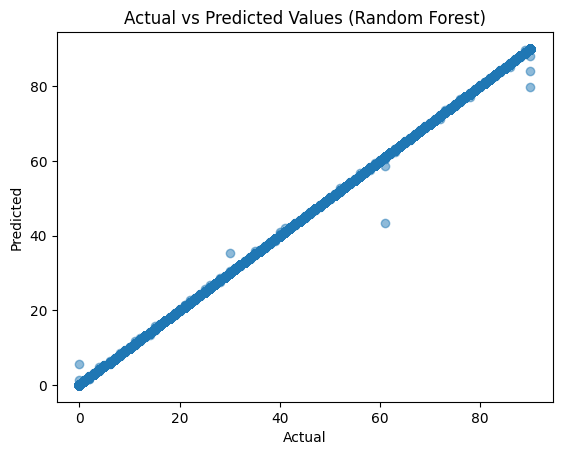

In [54]:
#Visualize predicted vs actual values
plt.scatter(result['actual'], result['predicted'], alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.show()

# Tensorflow Neural Networks

The dataset (X and y) is split into training and testing sets using an 80-20 split.
X contains the features, and y contains the target variable.
random_state=42 ensures that the split is reproducible.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The features in X_train and X_test are scaled to have a mean of 0 and a standard deviation of 1, which is crucial for training neural networks as it helps with convergence. fit_transform() is applied to the training data to learn the scaling parameters and apply the transformation.
transform() is applied to the test data using the parameters learned from the training data to ensure consistency.

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

A simple feedforward neural network is created using TensorFlow's Sequential API.
The network has two hidden layers, each with 64 neurons and ReLU activation.
The output layer has one neuron without an activation function because this is a regression problem where we predict a continuous value. 

The Adam optimizer is used to compile the model, which is a popular choice due to its adaptive learning rate and momentum.

Mean Squared Error (MSE) is used as the loss function, which is standard for regression tasks.

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with one unit for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The model is trained on the training data (X_train, y_train) for 50 epochs with a batch size of 32. 20% of the training data is used as a validation set to monitor the model's performance during training.

In [58]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 581.3173 - val_loss: 195.2704
Epoch 2/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - loss: 171.7861 - val_loss: 122.8546
Epoch 3/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step - loss: 107.5433 - val_loss: 72.5819
Epoch 4/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 62.7819 - val_loss: 45.2331
Epoch 5/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - loss: 39.8712 - val_loss: 34.7456
Epoch 6/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - loss: 30.2969 - val_loss: 29.7942
Epoch 7/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 25.5625 - val_loss: 24.0003
Epoch 8/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 22.5530 - val_loss: 20.2981
Epoch 9/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 20.1079 - val_loss: 20.2758
Epoch 10/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 18.8277 - val_loss: 18.1906
Epoch 11/50
2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 17.9206 - val_loss: 18.

The model's performance is evaluated on the test set (X_test, y_test).
The Mean Squared Error (MSE) between the actual and predicted values on the test set is printed.

In [59]:
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3182
Mean Squared Error: 8.475301742553711


The trained model is used to predict the target values (y_pred) for the test data.

A scatter plot is created to compare the actual values (y_test) against the predicted values (y_pred).
If the model performs well, the points should lie close to a diagonal line where Actual = Predicted.

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step


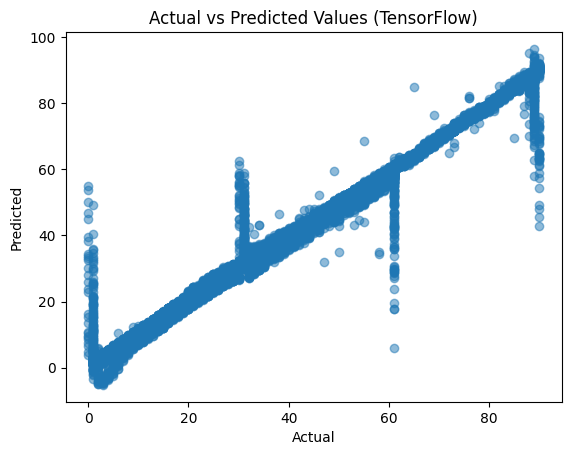

In [60]:
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (TensorFlow)')
plt.show()

# Pytorch Neural Networks

The dataset (X and y) is split into training and testing sets using an 80-20 split. X contains the features, and y contains the target variable. random_state=42 ensures that the split is reproducible.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The features in X_train and X_test are scaled to have a mean of 0 and a standard deviation of 1, which is crucial for training neural networks as it helps with convergence. fit_transform() is applied to the training data to learn the scaling parameters and apply the transformation. transform() is applied to the test data using the parameters learned from the training data to ensure consistency.

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The training and testing data (X_train, X_test, y_train, y_test) are converted from NumPy arrays to PyTorch tensors.
.view(-1, 1) reshapes the target variables (y_train, y_test) to have a single column, as required for regression output.

In [63]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)

Model Structure: A simple neural network is defined using PyTorch's nn.Module class.
fc1, fc2, fc3: These are fully connected layers.

Activation Function: ReLU is applied to the outputs of the first two layers.
Output Layer: The final layer (fc3) has one neuron, suitable for a regression task where we predict a single continuous value.

Model Instantiation: The model is instantiated by creating an object of the SimpleNN class.

In [64]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

Mean Squared Error (MSELoss) is used as the loss function, which is standard for regression.
The Adam optimizer is used to update the model's weights with a learning rate of 0.001.

In [65]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

The training loop runs for 50 epochs.

Training Phase:

model.train(): Sets the model to training mode.

optimizer.zero_grad(): Clears the gradients of all optimized variables to prepare for backpropagation.

output = model(X_train): The model makes predictions on the training data.

loss = criterion(output, y_train): The loss is calculated using the predictions and the actual values.

loss.backward(): Computes the gradient of the loss with respect to the model parameters.

optimizer.step(): Updates the model parameters using the calculated gradients.

Logging: Every 10 epochs, the current epoch number and the loss are printed.

In [66]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/50, Loss: 2451.623046875
Epoch 20/50, Loss: 2411.099609375
Epoch 30/50, Loss: 2350.89404296875
Epoch 40/50, Loss: 2261.751220703125
Epoch 50/50, Loss: 2137.74755859375


model.eval(): Sets the model to evaluation mode (disabling dropout, batch norm, etc.).

with torch.no_grad(): Temporarily disables gradient calculation, which reduces memory usage and speeds up computations.

y_pred = model(X_test): The model makes predictions on the test data.

mse = criterion(y_pred, y_test).item(): The Mean Squared Error between the predicted and actual test values is calculated and printed.

A scatter plot is created to visualize the actual vs. predicted values. The closer the points are to the diagonal line, the better the model's predictions.

Mean Squared Error: 2095.534912109375


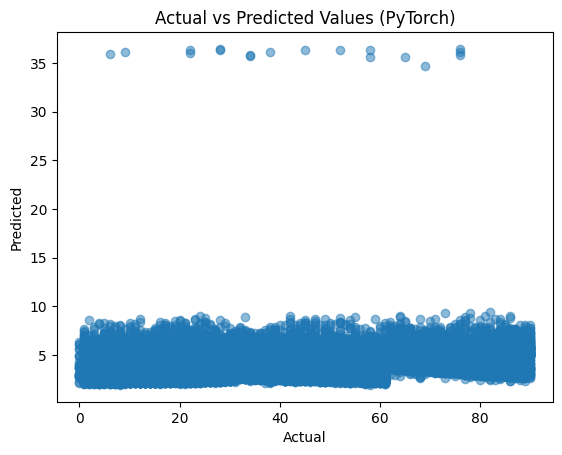

In [67]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test).item()
    print('Mean Squared Error:', mse)

y_pred = y_pred.numpy()
y_test = y_test.numpy()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (PyTorch)')
plt.show()
